In [4]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
assert float(tf.__version__[:3]) >= 2.3
import pathlib
import matplotlib.pylab as plt
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
DIR = "D:/SmartCar/TFLite_Smartcar/saved_models/1644237444"
data_dir = pathlib.Path("C:/Users/AORUS/dataset")
IMG_SIZE = 96

In [6]:
model = tf.keras.models.load_model(DIR)
TFLite_file = pathlib.Path(DIR)/"model.tflite"

In [7]:
from tf_augmentation import ds_augment

train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
train_ds = train_ds.cache().unbatch().take(100)
train_ds = ds_augment(train_ds).prefetch(buffer_size=AUTOTUNE)

Found 2369 files belonging to 15 classes.


In [8]:
test_images, test_labels = train_ds.batch(100).as_numpy_iterator().next()

In [6]:
def representative_data_gen():
    for image, label in train_ds.take(100):
        yield [tf.reshape(image, (1, IMG_SIZE, IMG_SIZE, 3))]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()
TFLite_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: C:\Users\AORUS\AppData\Local\Temp\tmp9u4_279a\assets


C:\Users\AORUS\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


7157360

In [7]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [9]:
def run_tflite_model(interpreter, test_image_indices):
    global test_images

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

def test_model(interpreter, test_image_index):
    global test_labels

    predictions = run_tflite_model(interpreter, [test_image_index])

    plt.imshow(test_images[test_image_index]/255)
    template = "True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)
    plt.axis('off')

def evaluate_model(interpreter):
    global test_images
    global test_labels
    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(interpreter, test_image_indices)
    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)
    print('accuracy is %.4f%% (Number of test samples=%d)' % (accuracy, len(test_images)))

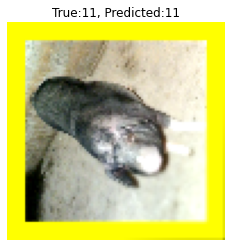

In [10]:
interpreter = tf.lite.Interpreter(model_path=str(TFLite_file))
interpreter.allocate_tensors()
test_model(interpreter, 4)

In [11]:
evaluate_model(interpreter)

accuracy is 93.0000% (Number of test samples=100)
